<a href="https://colab.research.google.com/github/NahinAlam001/499B/blob/main/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-q40uv67l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-q40uv67l
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=8817d1166b41c2915456a4e2c33c9808d24eff287fd3030cfad8a589fe1eda81
  Stored in directory: /tmp/pip-ephem-wheel-cache-vo3a32z9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from patchify import patchify
import random
from scipy import ndimage
import imageio

In [ ]:
import gdown
import zipfile

# Define the URL of the zip file and the destination directory for download
zip_url = 'https://drive.google.com/uc?id=1FomR78IlcqHqNi77fXAJCMgvEebihhF-'
zip_destination = '/content/colab_data.zip'

# Download the zip file
gdown.download(zip_url, zip_destination, quiet=False)

# Define the directory to extract the contents of the zip file
extract_dir = '/content'

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the contents of the zip file
with zipfile.ZipFile(zip_destination, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files and directories
extracted_files = os.listdir(extract_dir)
print("Extracted files and directories:", extracted_files)

Downloading...
From (original): https://drive.google.com/uc?id=1FomR78IlcqHqNi77fXAJCMgvEebihhF-
From (redirected): https://drive.google.com/uc?id=1FomR78IlcqHqNi77fXAJCMgvEebihhF-&confirm=t&uuid=ac383b14-9237-469c-9fee-4917763eff01
To: /content/colab_data.zip
100%|██████████| 212M/212M [00:01<00:00, 132MB/s]


Extracted files and directories: ['.config', 'colab_data.zip', '__MACOSX', 'drive', 'Dataset', 'sample_data']


In [ ]:
# Define the directory paths
image_dir = "/content/Dataset/images"
mask_dir = "/content/Dataset/masks"

In [ ]:
# Initialize lists to store images and masks
images = []
masks = []

# Iterate over image files
for file in sorted(os.listdir(image_dir)):
    # Read image and resize if necessary
    img = Image.open(os.path.join(image_dir, file))
    img = img.resize((256, 256))
    images.append(np.array(img))

# Iterate over mask files
for file in sorted(os.listdir(mask_dir)):
    # Read mask and resize if necessary
    mask = Image.open(os.path.join(mask_dir, file))
    mask = mask.resize((256, 256))
    masks.append(np.array(mask))

In [ ]:
# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Check the shapes of the arrays
print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (200, 256, 256, 3)
Mask shape: (200, 256, 256)


In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})

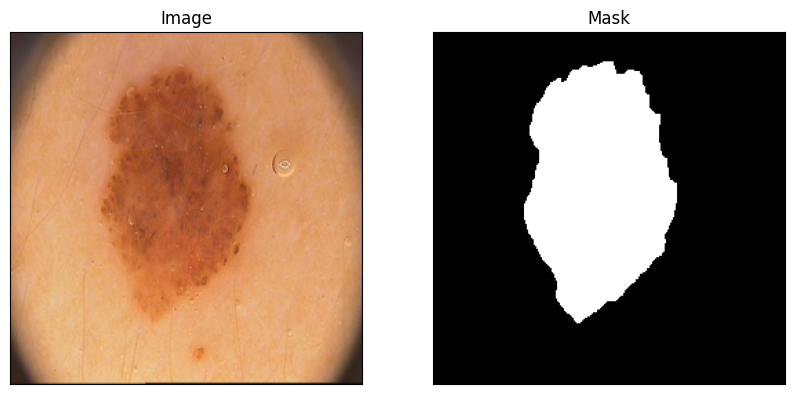

In [ ]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [ ]:
from transformers import SamModel

# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Ensure the model is properly loaded
assert isinstance(model, SamModel), "Loaded model is not of type SamModel"

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# Try DiceFocalLoss, FocalLoss, DiceCELoss directly from monai
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
  epoch_losses = []
  for batch in tqdm(train_dataloader):
    # forward pass
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)

    # compute loss
    predicted_masks = outputs.pred_masks.squeeze(1)
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)
    loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

    # backward pass (compute gradients of parameters w.r.t. loss)
    optimizer.zero_grad()
    loss.backward()

    # optimize
    optimizer.step()
    epoch_losses.append(loss.item())

  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


EPOCH: 0
Mean loss: 0.10025662861764431


100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


EPOCH: 1
Mean loss: 0.09982490994036197


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 2
Mean loss: 0.09908215433359147


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 3
Mean loss: 0.09971685945987702


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 4
Mean loss: 0.09476596675813198


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 5
Mean loss: 0.09214295320212841


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 6
Mean loss: 0.09094308227300645


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 7
Mean loss: 0.09111589226871729


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 8
Mean loss: 0.09224596263840795


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 9
Mean loss: 0.09341587129980326


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


EPOCH: 10
Mean loss: 0.09035162482410669


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 11
Mean loss: 0.08803070601075888


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 12
Mean loss: 0.08514510221779346


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 13
Mean loss: 0.08296184152364731


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 14
Mean loss: 0.08372842576354741


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 15
Mean loss: 0.09046282332390547


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 16
Mean loss: 0.08323767583817243


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 17
Mean loss: 0.08470462435856461


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


EPOCH: 18
Mean loss: 0.08231193920597434


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

EPOCH: 19
Mean loss: 0.0808193950727582


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/skin_model_checkpoint.pth")

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_skin_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_skin_model.load_state_dict(torch.load("/content/drive/MyDrive/skin_model_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_skin_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

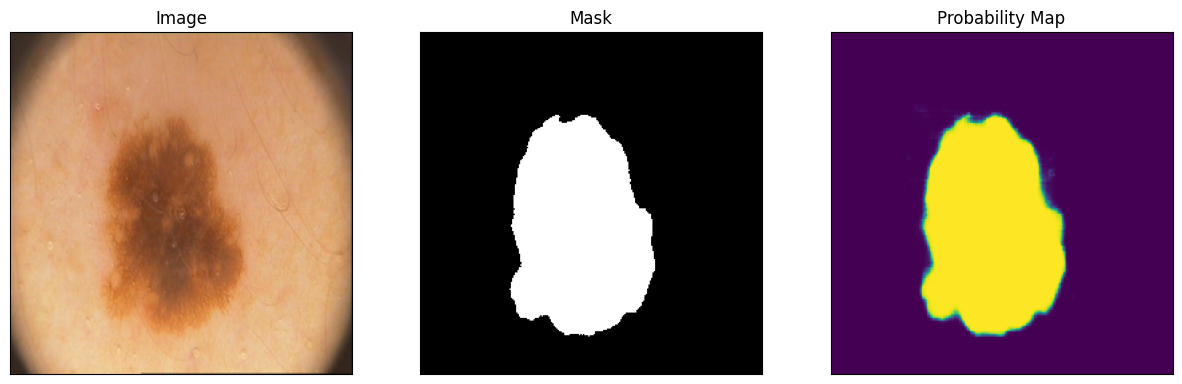

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_skin_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_skin_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

(1, 1, 100, 2)


In [32]:
# Create a directory to store the segmentation results if it doesn't exist
result_dir = "/content/result"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Iterate through all images in the dataset
for idx, sample in enumerate(dataset):
    # Load image
    test_image = sample["image"]

    # Get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(sample["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass
    with torch.no_grad():
        outputs = my_skin_model(**inputs, multimask_output=False)

    # Apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()

    # Thresholding
    threshold_value = 0.5  # Adjust threshold value if necessary
    medsam_seg = (medsam_seg_prob > threshold_value).astype(np.uint8)

    # Save segmentation result
    image_name = f"segmentation_result_{idx}.bmp"
    image_path = os.path.join(result_dir, image_name)
    imageio.imwrite(image_path, medsam_seg * 255)  # Scale the mask values to [0, 255]